In [1]:
import pandas as pd
import numpy as np
import sklearn.neighbors as sknb
import sklearn.impute as skimp
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import StratifiedKFold
import csv
import seaborn as sns

from evaluation import mean_absolute_error_results, mean_squared_error_results, root_mean_squared_error_results, r2_score_results, median_absolute_error_results

In [52]:
def load_csv_data(input_csv_filename, mode="clf", verbose=False):
    if verbose:
        print("Loading data from '{}' (mode={})...".format(input_csv_filename, mode))
    column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'name']
    df = pd.read_csv( input_csv_filename, delim_whitespace=True, names=column_names)
    df = df.replace('?', np.NAN)
    df = df.drop(['name', 'origin'], axis=1)
    # df = pd.read_csv(input_csv_filename)  # dataframe
    df_header = df.columns.values  # header
    header = list(df_header)
    N, d = len(df), len(df_header) - 1
    X = np.array(df.drop(['mpg'], axis=1))  # extract X by dropping y column
    y = np.array(df['mpg'])  # extract y
    y_classes = list(set(y))
    assert X.shape == (N, d)  # check X.shape
    assert y.shape == (N,)  # check y.shape
    if mode == "clf":
        assert y.dtype in ['int64']  # check y are integers
    elif mode == "regr":
        assert y.dtype in ['int64', 'float64']  # check y are integers/floats
    else:
        exit("err: invalid mode given!")
    if verbose:
        print(" header={}\n X.shape={}\n y.shape={}\n len(y_classes)={}\n".format(header, X.shape, y.shape, len(y_classes)))
    return X, y, header

In [ ]:
load_csv_data('../datasets/auto-mpg.data', mode="clf", verbose=False)

In [38]:

column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'name']
dataset = pd.read_csv('../datasets/auto-mpg.data', delim_whitespace=True, names=column_names)
dataset = dataset.replace('?', np.NAN)

In [39]:
dataset.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


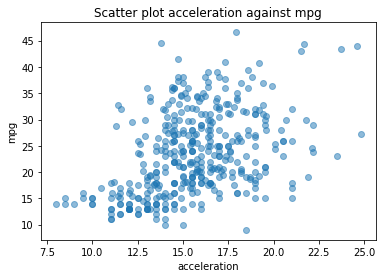

In [11]:
plt.scatter(dataset['acceleration'], dataset['mpg'], alpha=0.5)
plt.title('Scatter plot acceleration against mpg')
plt.xlabel('acceleration')
plt.ylabel('mpg')

plt.savefig("../graphs/AutoMPG/" + "scatter-acc-mpg" + ".png", bbox_inches='tight')
plt.show()

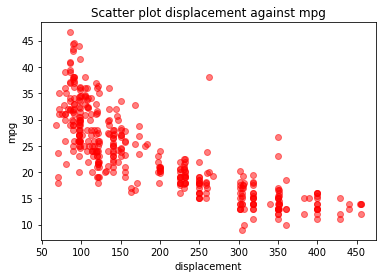

In [12]:
plt.scatter(dataset['displacement'], dataset['mpg'], color='red', alpha=0.5)
plt.title('Scatter plot displacement against mpg')
plt.xlabel('displacement')
plt.ylabel('mpg')

plt.savefig("../graphs/AutoMPG/" + "scatter-displacement-mpg" + ".png", bbox_inches='tight')

plt.show()

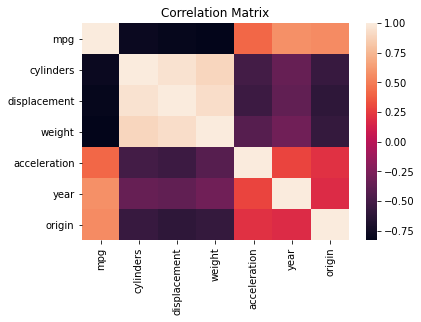

In [14]:
sns.heatmap(dataset.corr())
plt.title('Correlation Matrix')
plt.savefig("../graphs/AutoMPG/" + "corr-matrix" + ".png", bbox_inches='tight')

plt.show()

In [15]:
null_counts

NameError: name 'null_counts' is not defined

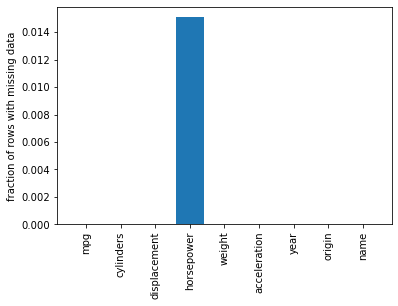

In [5]:
null_counts = dataset.isnull().sum()/len(dataset)

plt.xticks(np.arange(len(null_counts)), null_counts.index, rotation='vertical')
plt.ylabel('fraction of rows with missing data')
plt.bar(np.arange(len(null_counts)),null_counts)

plt.savefig("../graphs/AutoMPG/" + "missing-vals" + ".png", bbox_inches='tight')



In [40]:

print(dataset.isna().sum())

dataset.dropna(inplace=True)
print(dataset.isna().sum())

dataset = dataset.drop(['name', 'origin'], axis=1)

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64
mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64


In [41]:
from utilis import load_csv_data
mode = "regr"
X = np.array(dataset.drop(['mpg'], axis=1))  # extract X by dropping y column
y = np.array(dataset['mpg'])  # extract y

In [42]:
X

array([[8, 307.0, '130.0', 3504.0, 12.0, 70],
       [8, 350.0, '165.0', 3693.0, 11.5, 70],
       [8, 318.0, '150.0', 3436.0, 11.0, 70],
       ...,
       [4, 135.0, '84.00', 2295.0, 11.6, 82],
       [4, 120.0, '79.00', 2625.0, 18.6, 82],
       [4, 119.0, '82.00', 2720.0, 19.4, 82]], dtype=object)

In [43]:
y

array([18. , 15. , 18. , 16. , 17. , 15. , 14. , 14. , 14. , 15. , 15. ,
       14. , 15. , 14. , 24. , 22. , 18. , 21. , 27. , 26. , 25. , 24. ,
       25. , 26. , 21. , 10. , 10. , 11. ,  9. , 27. , 28. , 25. , 19. ,
       16. , 17. , 19. , 18. , 14. , 14. , 14. , 14. , 12. , 13. , 13. ,
       18. , 22. , 19. , 18. , 23. , 28. , 30. , 30. , 31. , 35. , 27. ,
       26. , 24. , 25. , 23. , 20. , 21. , 13. , 14. , 15. , 14. , 17. ,
       11. , 13. , 12. , 13. , 19. , 15. , 13. , 13. , 14. , 18. , 22. ,
       21. , 26. , 22. , 28. , 23. , 28. , 27. , 13. , 14. , 13. , 14. ,
       15. , 12. , 13. , 13. , 14. , 13. , 12. , 13. , 18. , 16. , 18. ,
       18. , 23. , 26. , 11. , 12. , 13. , 12. , 18. , 20. , 21. , 22. ,
       18. , 19. , 21. , 26. , 15. , 16. , 29. , 24. , 20. , 19. , 15. ,
       24. , 20. , 11. , 20. , 19. , 15. , 31. , 26. , 32. , 25. , 16. ,
       16. , 18. , 16. , 13. , 14. , 14. , 14. , 29. , 26. , 26. , 31. ,
       32. , 28. , 24. , 26. , 24. , 26. , 31. , 19

In [44]:
from scaling import minMaxScailing
from data_handler import trainTestSplit

X = dataset.drop(['mpg'], axis=1)
Y = dataset['mpg']

x_train, x_test, y_train, y_test = trainTestSplit(X, Y)

x_train, x_test = minMaxScailing(x_train, x_test)


In [45]:
X_train = pd.DataFrame(x_train, columns = ['cylinders','displacement','horsepower','weight','acceleration','year'])

In [46]:
y_train = pd.DataFrame(y_train, columns = ['mpg'])

In [47]:
np.array(X)

array([[8, 307.0, '130.0', 3504.0, 12.0, 70],
       [8, 350.0, '165.0', 3693.0, 11.5, 70],
       [8, 318.0, '150.0', 3436.0, 11.0, 70],
       ...,
       [4, 135.0, '84.00', 2295.0, 11.6, 82],
       [4, 120.0, '79.00', 2625.0, 18.6, 82],
       [4, 119.0, '82.00', 2720.0, 19.4, 82]], dtype=object)

## Model tree by hand


In [50]:
from linear_regr import linear_regr
from ModelTree import ModelTree
# Choose model
model = linear_regr()

# Build model tree
model_tree = ModelTree(model, max_depth=2, min_samples_leaf=5,
                           search_type="greedy", n_search_grid=100)

In [51]:
# ====================
# Train model tree
# ====================
print("Training model tree with '{}'...".format(model.__class__.__name__))
model_tree.fit(X, y, verbose=True)
# y_pred = model_tree.predict(x_test)


Training model tree with 'linear_regr'...


KeyError: (0, 0)

In [67]:


print("MAE: {}".format(mean_absolute_error_results(y_test, y_pred)))
print("MSE: {}".format(mean_squared_error_results(y_test, y_pred)))
print("RMS: {}".format(root_mean_squared_error_results(y_test, y_pred)))
print("R2S: {}".format(r2_score_results(y_test, y_pred)))
print("MDAE: {}".format(median_absolute_error_results(y_test, y_pred)))

MAE: 2.3772151898734175
MSE: 13.029367088607597
RMS: 3.6096214605700134
R2S: 0.7609405426756821
MDAE: 1.8999999999999986


In [68]:
mses = []
maes = []
r2s = []
r2s = []
for k in range(1,50):
    y_hat_test = knn_predict(x_train, x_test, y_train, y_test, k, p=1)
    mses.append(mean_squared_error_results(y_test, y_hat_test))
    r2s.append(r2_score_results(y_test, y_hat_test))
    maes.append(mean_absolute_error_results(y_test, y_hat_test))
    r2s.append(root_mean_squared_error_results(y_test, y_hat_test))

# Plot the results 

In [77]:
print(min(mses))
mses[12]

7.336962025316455


7.336962025316455

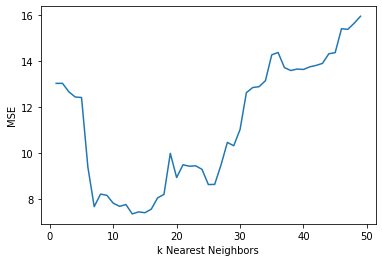

In [71]:
# fig, ax = plt.subplots(figsize=(8,6))
fig, ax = plt.subplots()
ax.plot(range(1,50), mses)
ax.set_xlabel('k Nearest Neighbors')
ax.set_ylabel('MSE')

plt.savefig("./graphs/AutoMPG/" + "knn-scratch" + ".png", bbox_inches='tight')

In [ ]:
Gradient Descent Algorithm

In [10]:
from gradient_descent import gradient_descent, predict
weight_gradient_descent, cost_history = gradient_descent(x_train, y_train, 0.00000003, 1000)
y_pred = predict(weight_gradient_descent, x_test)

print("MAE: {}".format(mean_absolute_error_results(y_test, y_pred)))
print("MSE: {}".format(mean_squared_error_results(y_test, y_pred)))
print("RMS: {}".format(root_mean_squared_error_results(y_test, y_pred)))
print("R2S: {}".format(r2_score_results(y_test, y_pred)))
print("MDAE: {}".format(median_absolute_error_results(y_test, y_pred)))

MAE: 22.868891661799115
MSE: 577.4910371300111
RMS: 24.03104319687373
R2S: -9.595656182460921
MDAE: 21.999587770236325


In [19]:
alphas = [0.1,0.01,0.001,0.0001,0.00001]

mses = []
maes = []
r2s = []
r2s = []
for a in alphas:
    print(a)
    weight_gradient_descent, cost_history = gradient_descent(x_train, y_train, a, 1000)
    y_hat_test = predict(weight_gradient_descent, x_test)
    mses.append(mean_squared_error_results(y_test, y_hat_test))
    r2s.append(r2_score_results(y_test, y_hat_test))
    maes.append(mean_absolute_error_results(y_test, y_hat_test))
    r2s.append(root_mean_squared_error_results(y_test, y_hat_test))


0.1
0.01
0.001
0.0001
1e-05


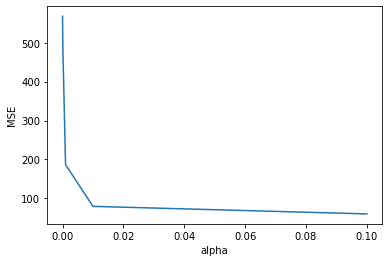

In [21]:
fig, ax = plt.subplots()
ax.plot(alphas, mses)
ax.set_xlabel('alpha')
ax.set_ylabel('MSE')

plt.savefig("./graphs/AutoMPG/" + "gd-alpha-scratch" + ".png", bbox_inches='tight')

In [22]:
numIter = [1000, 5000, 10000]

mses = []
maes = []
r2s = []
r2s = []
for n in numIter:
    print(n)
    weight_gradient_descent, cost_history = gradient_descent(x_train, y_train, 0.1, n)
    y_hat_test = predict(weight_gradient_descent, x_test)
    mses.append(mean_squared_error_results(y_test, y_hat_test))
    r2s.append(r2_score_results(y_test, y_hat_test))
    maes.append(mean_absolute_error_results(y_test, y_hat_test))
    r2s.append(root_mean_squared_error_results(y_test, y_hat_test))

1000
5000
10000


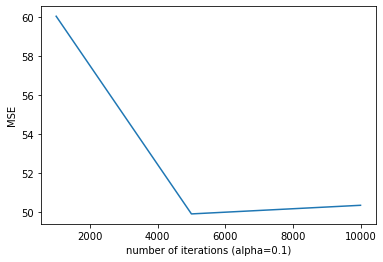

In [23]:
fig, ax = plt.subplots()
ax.plot(numIter, mses)
ax.set_xlabel('number of iterations (alpha=0.1)')
ax.set_ylabel('MSE')

plt.savefig("./graphs/AutoMPG/" + "gd-numIter-scratch" + ".png", bbox_inches='tight')

In [40]:
# best parameters

weight_gradient_descent, cost_history = gradient_descent(x_train, y_train, 0.1, 50000)
Sgd_byhand_y_best_pred = predict(weight_gradient_descent, x_test)

sgd_byhand_mse = mean_squared_error_results(y_test, Sgd_byhand_y_best_pred)


In [41]:
knn_byhandy_hat_test = knn_predict(x_train, x_test, y_train, y_test, k=2, p=1)
knn_byhand_mse = mean_squared_error_results(y_test, knn_byhandy_hat_test)

In [ ]:
## Comparision against algorithms implemented in sklearn

In [42]:
from sklearn.linear_model import SGDRegressor
rg = SGDRegressor(max_iter=50000, alpha=0.1)
rg.fit(x_train, y_train.to_numpy())
sgd_y_pred_test = rg.predict(x_test)

sgd_mse = mean_squared_error_results(y_test, sgd_y_pred_test)

print("MAE: {}".format(mean_absolute_error_results(y_test, sgd_y_pred_test)))
print("MSE: {}".format(mean_squared_error_results(y_test, sgd_y_pred_test)))
print("RMS: {}".format(root_mean_squared_error_results(y_test, sgd_y_pred_test)))
print("R2S: {}".format(r2_score_results(y_test, sgd_y_pred_test)))
print("MDAE: {}".format(median_absolute_error_results(y_test, sgd_y_pred_test)))

MAE: 3.1564678448078496
MSE: 15.381690486823564
RMS: 3.9219498322675626
R2S: 0.7177807213885454
MDAE: 2.5012563990355403


In [43]:
from sklearn.neighbors import KNeighborsRegressor

clf = KNeighborsRegressor(n_neighbors=4, p=1)
clf.fit(x_train, y_train.to_numpy())
y_pred_test = clf.predict(x_test)

knn_mse = mean_squared_error_results(y_test, y_pred_test)
print("MAE: {}".format(mean_absolute_error_results(y_test, y_pred_test)))
print("MSE: {}".format(mean_squared_error_results(y_test, y_pred_test)))
print("RMS: {}".format(root_mean_squared_error_results(y_test, y_pred_test)))
print("R2S: {}".format(r2_score_results(y_test, y_pred_test)))
print("MDAE: {}".format(median_absolute_error_results(y_test, y_pred_test)))

MAE: 1.80126582278481
MSE: 8.342911392405062
RMS: 2.8884098380259444
R2S: 0.8469264196480351
MDAE: 1.5


In [44]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, criterion= "mse")
rf.fit(x_train, y_train)
rf_y = rf.predict(x_test)
rf_mse = mean_squared_error_results(y_test, rf_y)
print("MAE: {}".format(mean_absolute_error_results(y_test, rf_y)))
print("MSE: {}".format(mean_squared_error_results(y_test, rf_y)))
print("RMS: {}".format(root_mean_squared_error_results(y_test, rf_y)))
print("R2S: {}".format(r2_score_results(y_test, rf_y)))
print("MDAE: {}".format(median_absolute_error_results(y_test, rf_y)))

MAE: 1.8703291139240517
MSE: 7.722196430379752
RMS: 2.778884026075891
R2S: 0.8583151372247008
MDAE: 1.283999999999999


In [45]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(x_train, y_train)
r_pred = lr.predict(x_test)

lr_mse = mean_squared_error_results(y_test, r_pred)

print("MAE: {}".format(mean_absolute_error_results(y_test, r_pred)))
print("MSE: {}".format(mean_squared_error_results(y_test, r_pred)))
print("RMS: {}".format(root_mean_squared_error_results(y_test, r_pred)))
print("R2S: {}".format(r2_score_results(y_test, r_pred)))
print("MDAE: {}".format(median_absolute_error_results(y_test, r_pred)))


MAE: 2.7985300311188683
MSE: 12.487396230213015
RMS: 3.5337510141792694
R2S: 0.7708844838059223
MDAE: 2.45901769203169


In [46]:
# comparision

mse_list = [sgd_byhand_mse,  knn_byhand_mse, sgd_mse, knn_mse, rf_mse, lr_mse]




In [47]:
mse_list

[50.68048315611228,
 13.029367088607597,
 15.381690486823564,
 8.342911392405062,
 7.722196430379752,
 12.487396230213015]